## Interpretação de Modelos de Machine Learning - Parte 1

Código por [Jéssica Ramos](https://www.linkedin.com/in/jessicalfr/)

### Preparação do ambiente e do banco de dados

In [1]:
## versão do R
R.Version()$version.string

[1] "R version 4.0.2 (2020-06-22)"

In [2]:
## pacotes
library(tidyverse) # versão 1.3.0
library(magrittr) # versão 1.5
library(h2o) # versão 3.30.0.7
library(vip) # versão 0.2.2

# opções
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res=200)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: 'h2o'


The following objects are masked from 'packag

O *dataset* utilizado é uma base de casas para alugar no Brasil, disponível no [Kaggle](https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent?select=houses_to_rent_v2.csv). O arquivo utilizado é a versão 2 da base, que contém 10.692 observações e 13 variáveis, sendo elas:

- `city`: A cidade onde se encontra o imóvel;
- `area`: A area do imóvel em m²;
- `rooms`: O número de quartos;
- `bathroom`: O número de banheiros;
- `parking spaces`: O número de vagas de garagem;
- `floor`: O andar do imóvel;
- `animal`: Se animais são aceitos;
- `furniture`: Se o apartamento é mobiliado;
- `hoa`: Valor do condomínio em reais;
- `rent amount`: Valor do aluguel em reais;
- `property tax`: Valor do IPTU em reais;
- `fire insurance`: Valor do seguro incêndio em reais;
- `total`: Soma dos custos (aluguel, condomínio, IPTU e seguro incêndio) em reais.

Vamos então ler e explorar o *dataset*.

In [3]:
## dados
df = read_csv('datasets_554905_1035602_houses_to_rent_v2.csv')

# ajusta os nomes
names(df) = c('city','area','rooms','bathrooms','parking_spaces','floor','animal','furniture',
              'hoa','rent_amount','property_tax','fire_insurance','total')
head(df)

Parsed with column specification:
cols(
  city = col_character(),
  area = col_double(),
  rooms = col_double(),
  bathroom = col_double(),
  `parking spaces` = col_double(),
  floor = col_character(),
  animal = col_character(),
  furniture = col_character(),
  `hoa (R$)` = col_double(),
  `rent amount (R$)` = col_double(),
  `property tax (R$)` = col_double(),
  `fire insurance (R$)` = col_double(),
  `total (R$)` = col_double()
)



city,area,rooms,bathrooms,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
São Paulo,376,3,3,7,-,acept,not furnished,0,8000,834,121,8955


Vamos usar como variável resposta a coluna `total`.

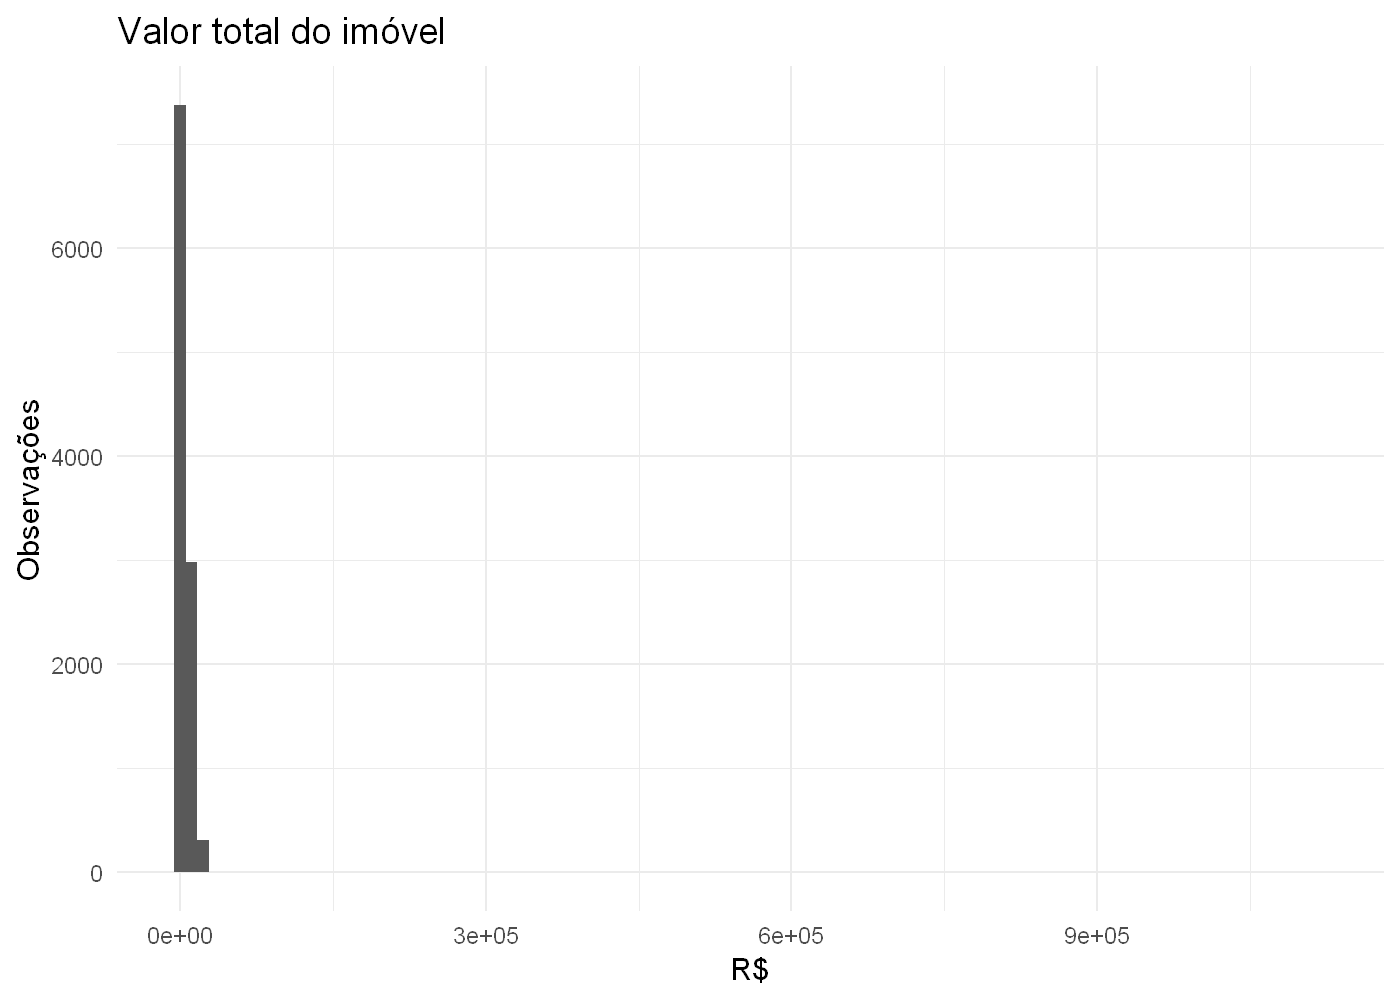

In [4]:
# distribuição do target
ggplot(df) +
    geom_histogram(aes(x=total), bins = 100) +
    ggtitle(label = 'Valor total do imóvel') +
    labs(x = 'R$', y = 'Observações') +
    theme_minimal()

O *target* tem distribuição fortemente assimétrica. Para facilitar as análises do modelo de regressão linear, vamos trabalhar com o log do *target* como variável resposta.

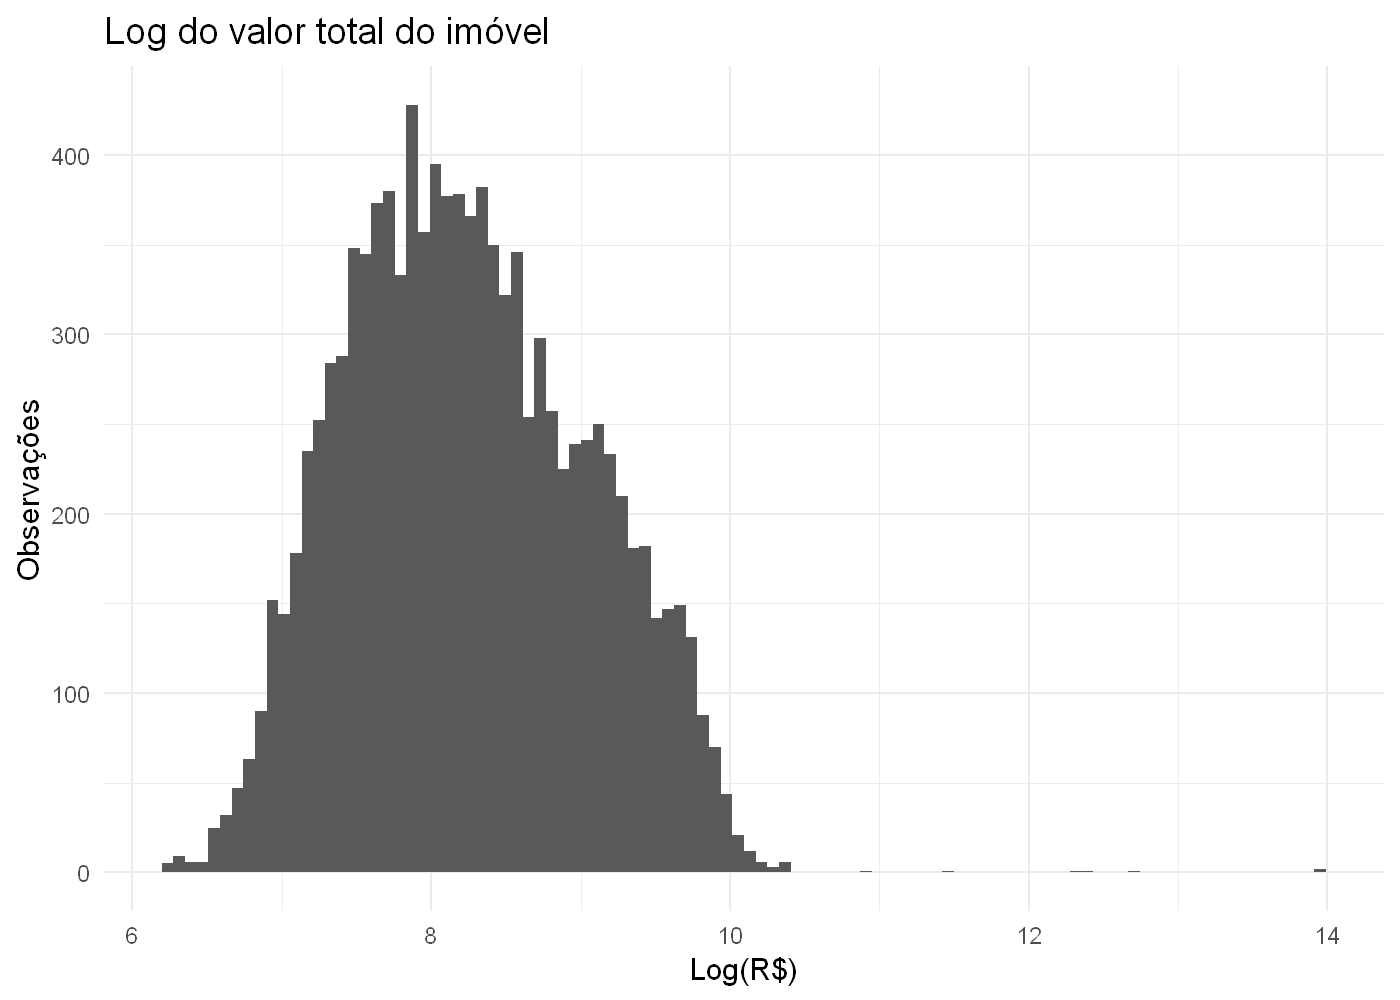

In [5]:
# cria o log do target
df = df %>%
    mutate(log_total = log(total))

# visualização do novo target
ggplot(df) +
    geom_histogram(aes(x=log_total), bins = 100) +
    ggtitle(label = 'Log do valor total do imóvel') +
    labs(x = 'Log(R$)', y = 'Observações') +
    theme_minimal()

Ainda é possível ver *outliers*, mas essa é uma distribuição mais simétrica e mais compatível com as premissas do modelo de regressão linear.

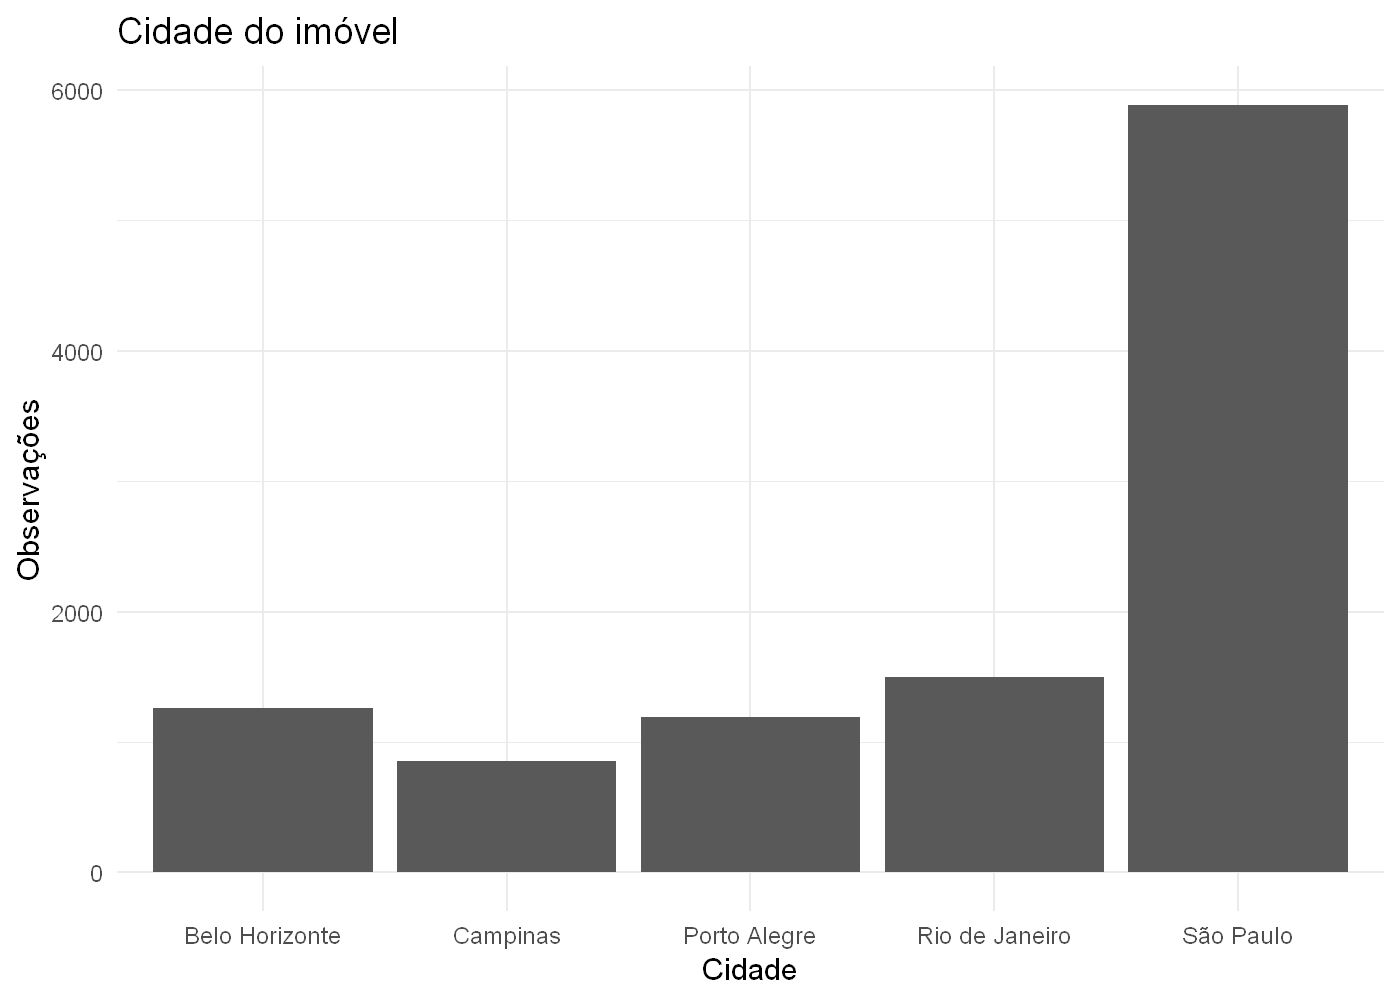

In [6]:
# cidade
ggplot(df) +
    geom_bar(aes(x=city)) +
    ggtitle(label = 'Cidade do imóvel') +
    labs(x = 'Cidade', y = 'Observações') +
    theme_minimal()

A maior parte dos imóveis na base são em São Paulo. A variável será transformada em fator, para que a cidade de São Paulo seja a referência na criação das indicadoras adiante.

In [7]:
# transforma cidade em fator
df$city %<>% factor(c('São Paulo','Rio de Janeiro','Belo Horizonte','Porto Alegre','Campinas'))

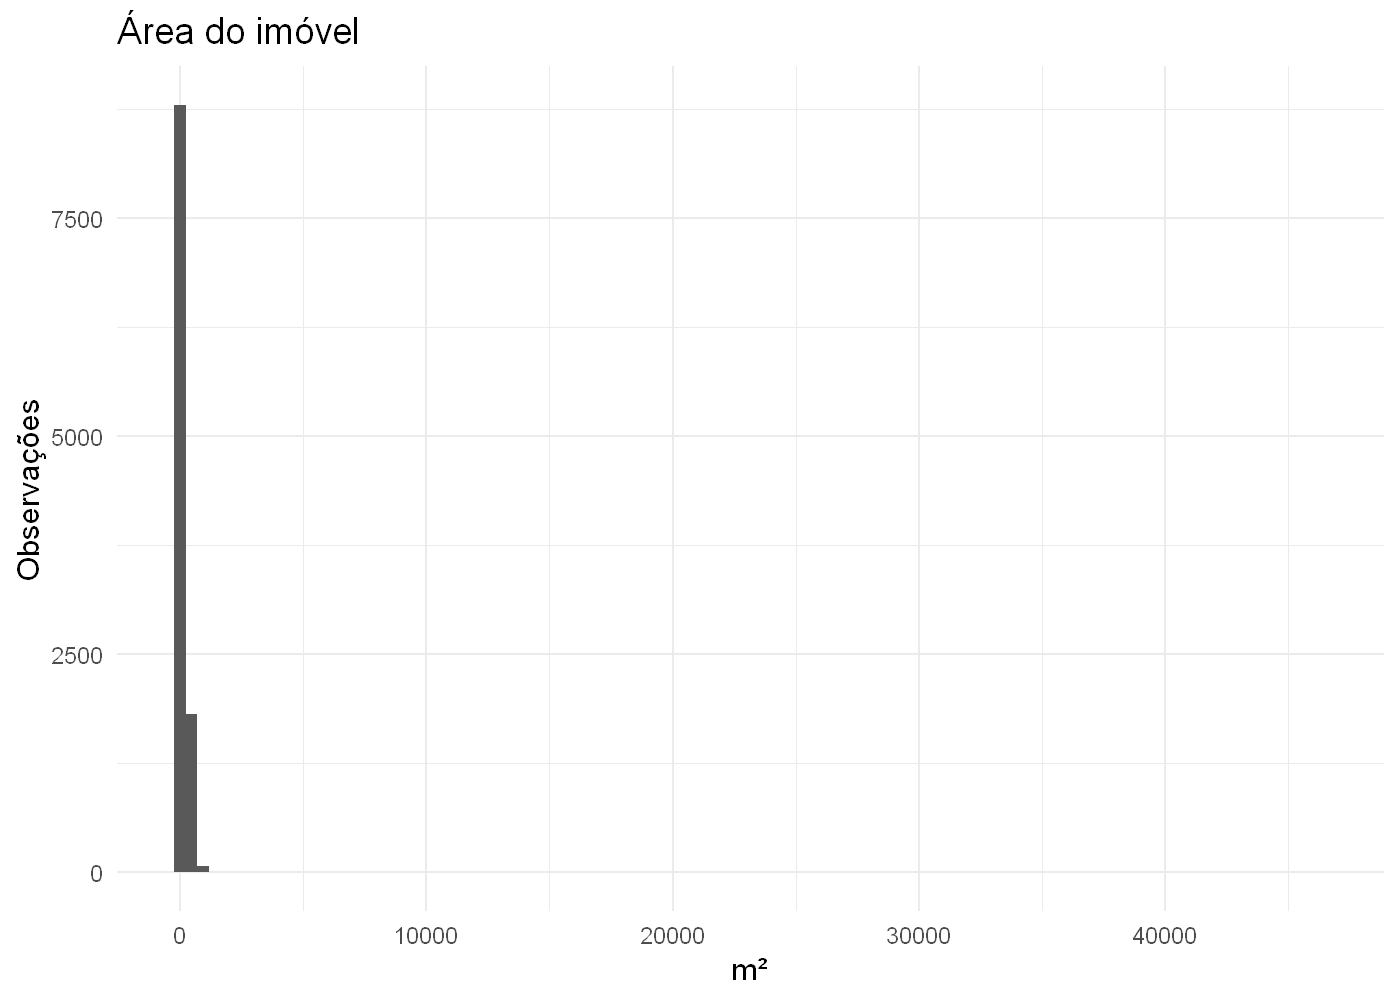

In [8]:
# area do imóvel
ggplot(df) +
    geom_histogram(aes(x=area), bins = 100) +
    ggtitle(label = 'Área do imóvel') +
    labs(x = 'm²', y = 'Observações') +
    theme_minimal()

In [9]:
# medidas
summary(df$area)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   11.0    56.0    90.0   149.2   182.0 46335.0 

A área do imóvel também tem uma distribuição assimétrica, porém não será feita nenhuma transformação.

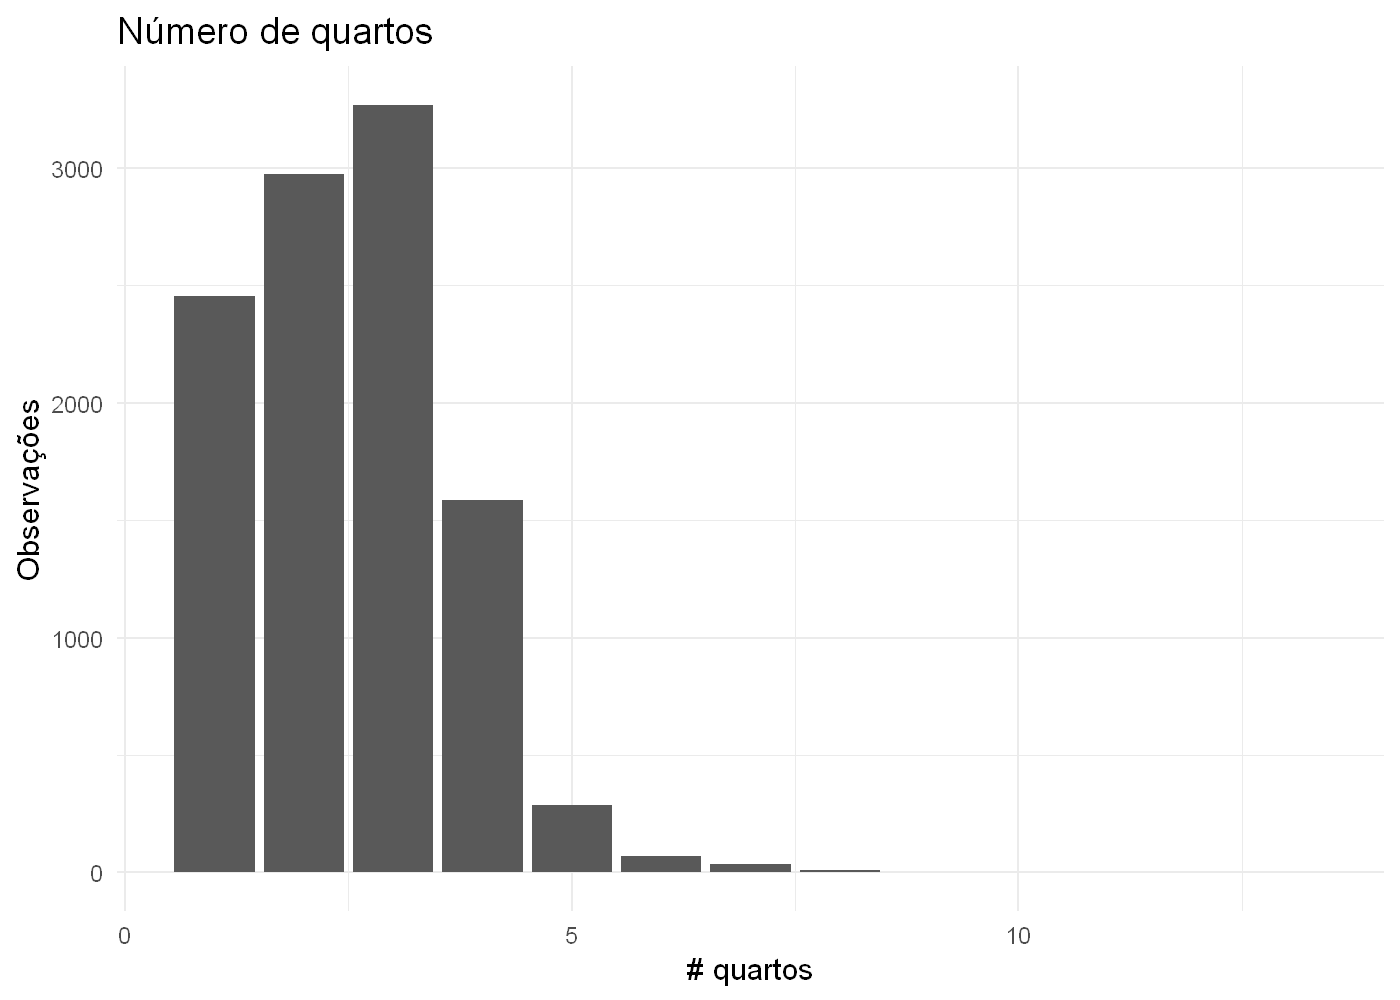

In [10]:
# número de quartos
ggplot(df) +
    geom_bar(aes(x=rooms)) +
    ggtitle(label = 'Número de quartos') +
    labs(x = '# quartos', y = 'Observações') +
    theme_minimal()

In [11]:
# medidas
summary(df$rooms)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   2.000   2.506   3.000  13.000 

Pelo menos metade dos imóveis têm até 2 quartos.

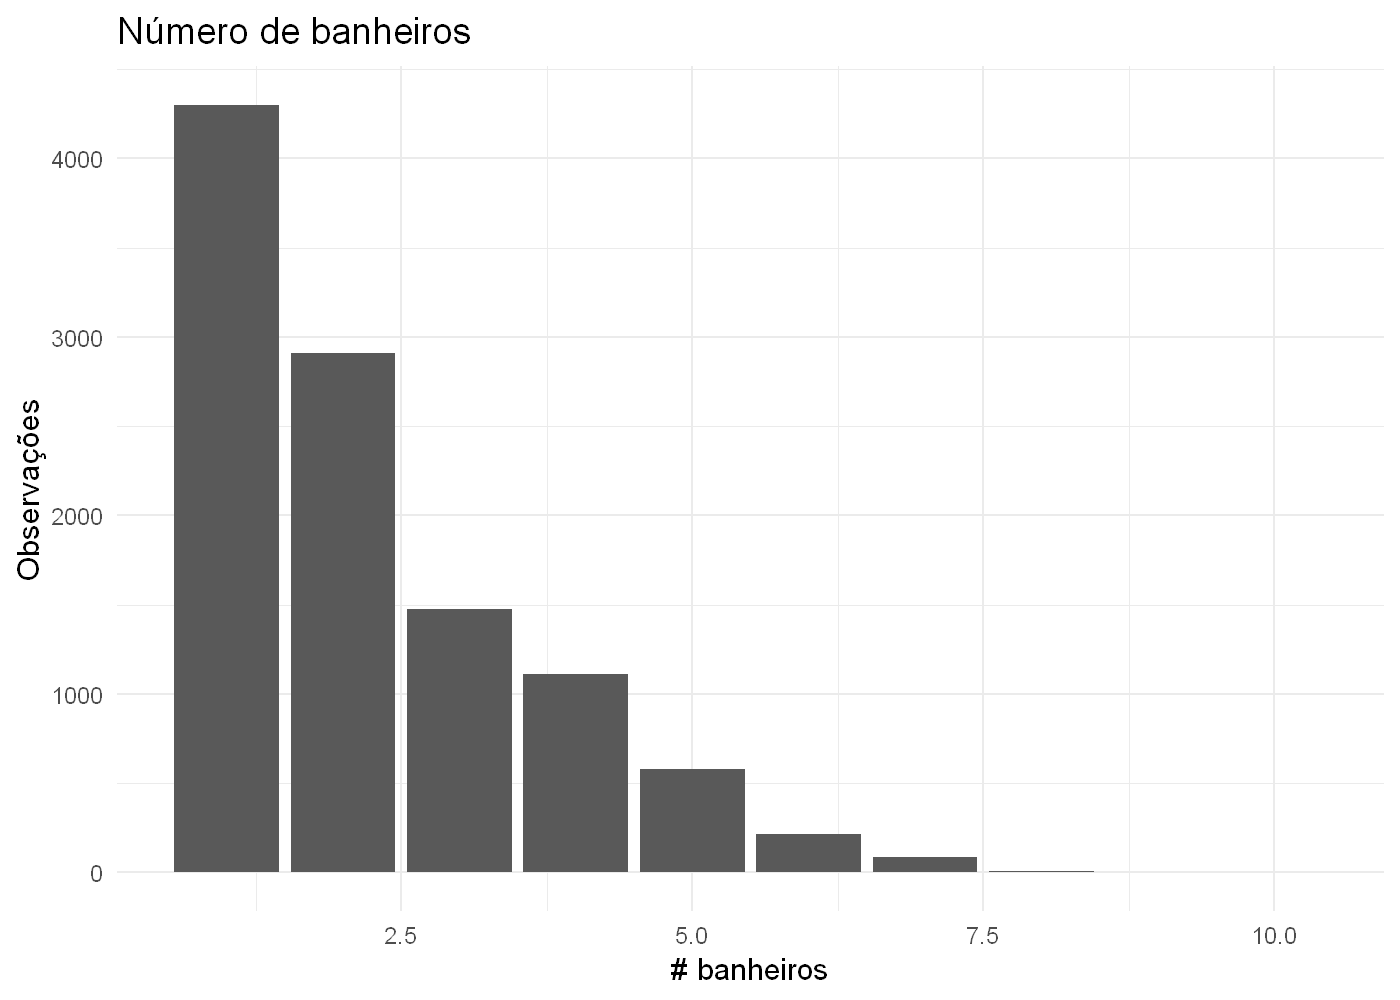

In [12]:
# número de banheiros
ggplot(df) +
    geom_bar(aes(x=bathrooms)) +
    ggtitle(label = 'Número de banheiros') +
    labs(x = '# banheiros', y = 'Observações') +
    theme_minimal()

In [13]:
# medidas
summary(df$bathrooms)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.237   3.000  10.000 

A maioria dos imóveis têm apenas 1 banheiro. Quanto maior o número de banheiros, menor a frequência de imóveis.

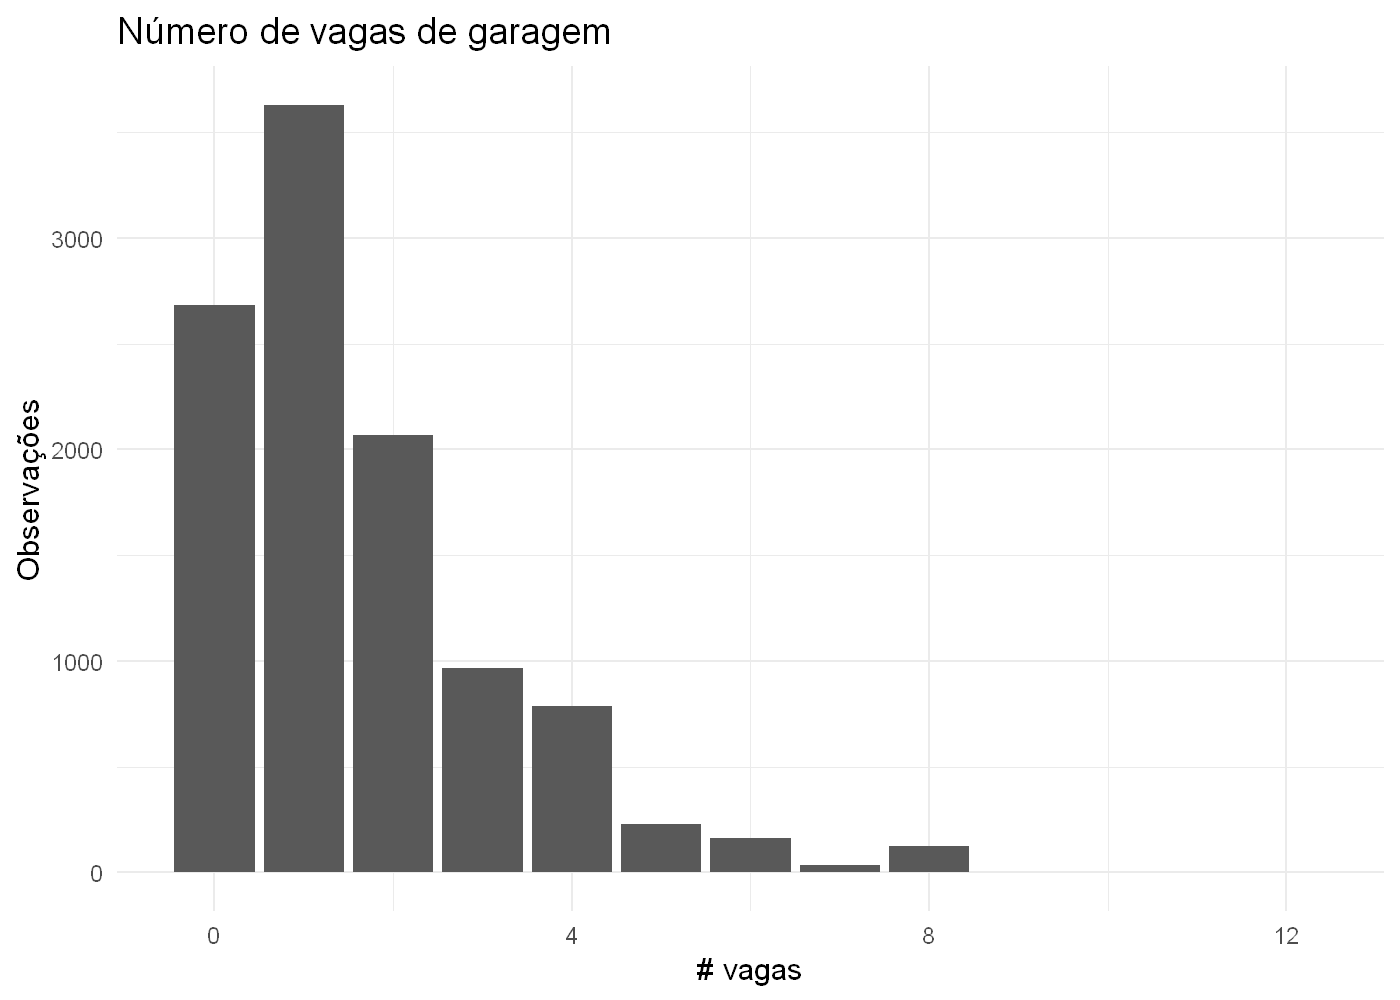

In [14]:
# número de vagas de garagem
ggplot(df) +
    geom_bar(aes(x=parking_spaces)) +
    ggtitle(label = 'Número de vagas de garagem') +
    labs(x = '# vagas', y = 'Observações') +
    theme_minimal()

In [15]:
# medidas
summary(df$parking_spaces)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   1.609   2.000  12.000 

Um número grande de imóveis não têm nenhuma vaga de garagem.

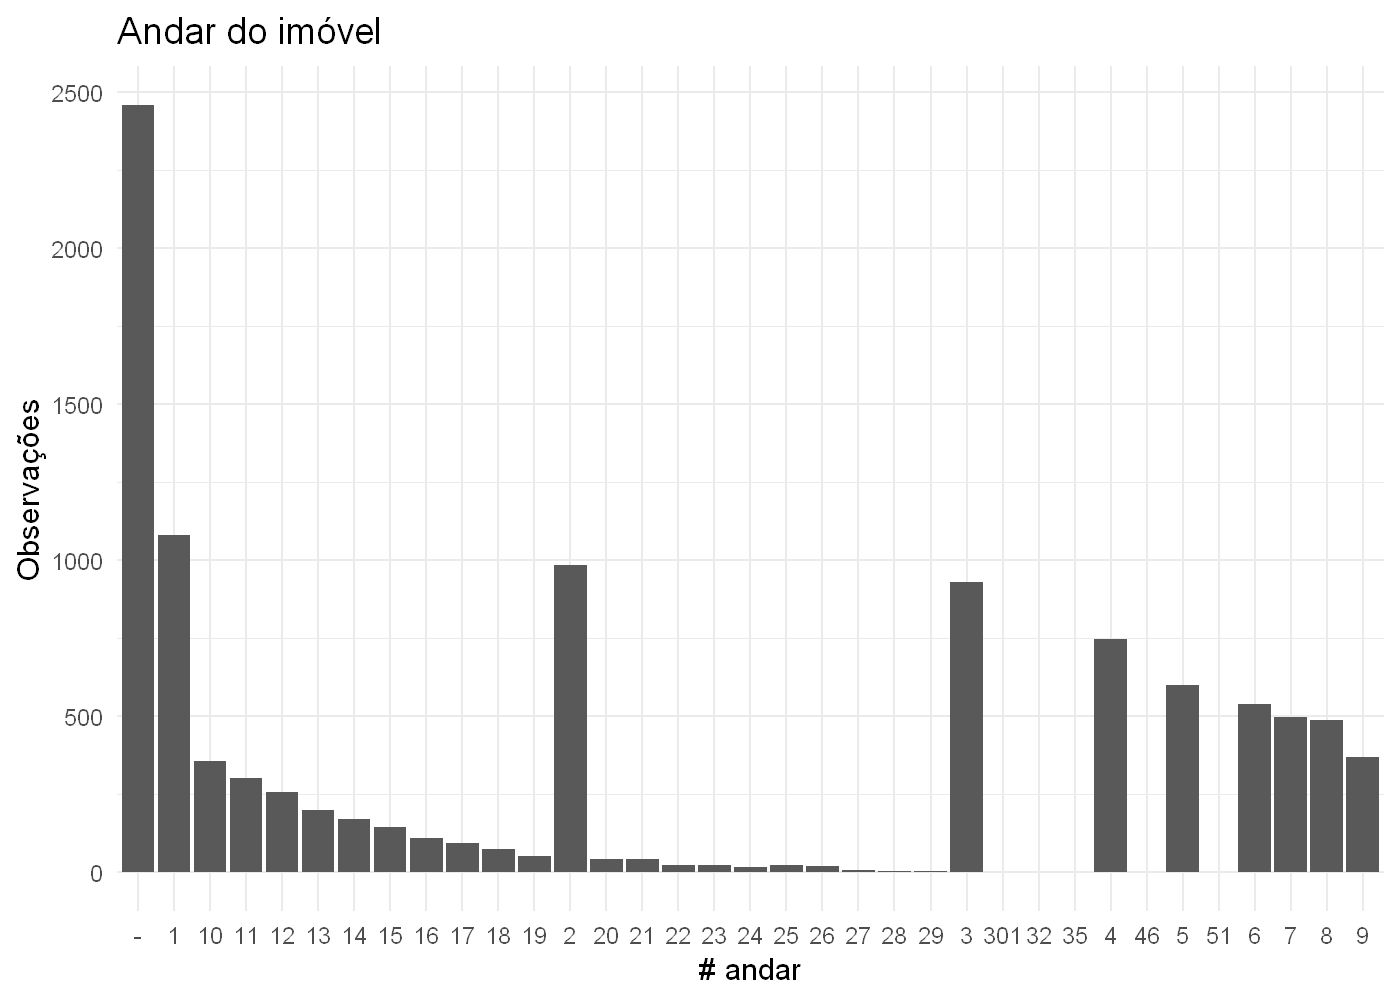

In [16]:
# andar do imóvel
ggplot(df) +
    geom_bar(aes(x=floor)) +
    ggtitle(label = 'Andar do imóvel') +
    labs(x = '# andar', y = 'Observações') +
    theme_minimal()

O andar do imóvel é uma variável categórica. Vamos subdividir essa variável em um número menor de categorias.

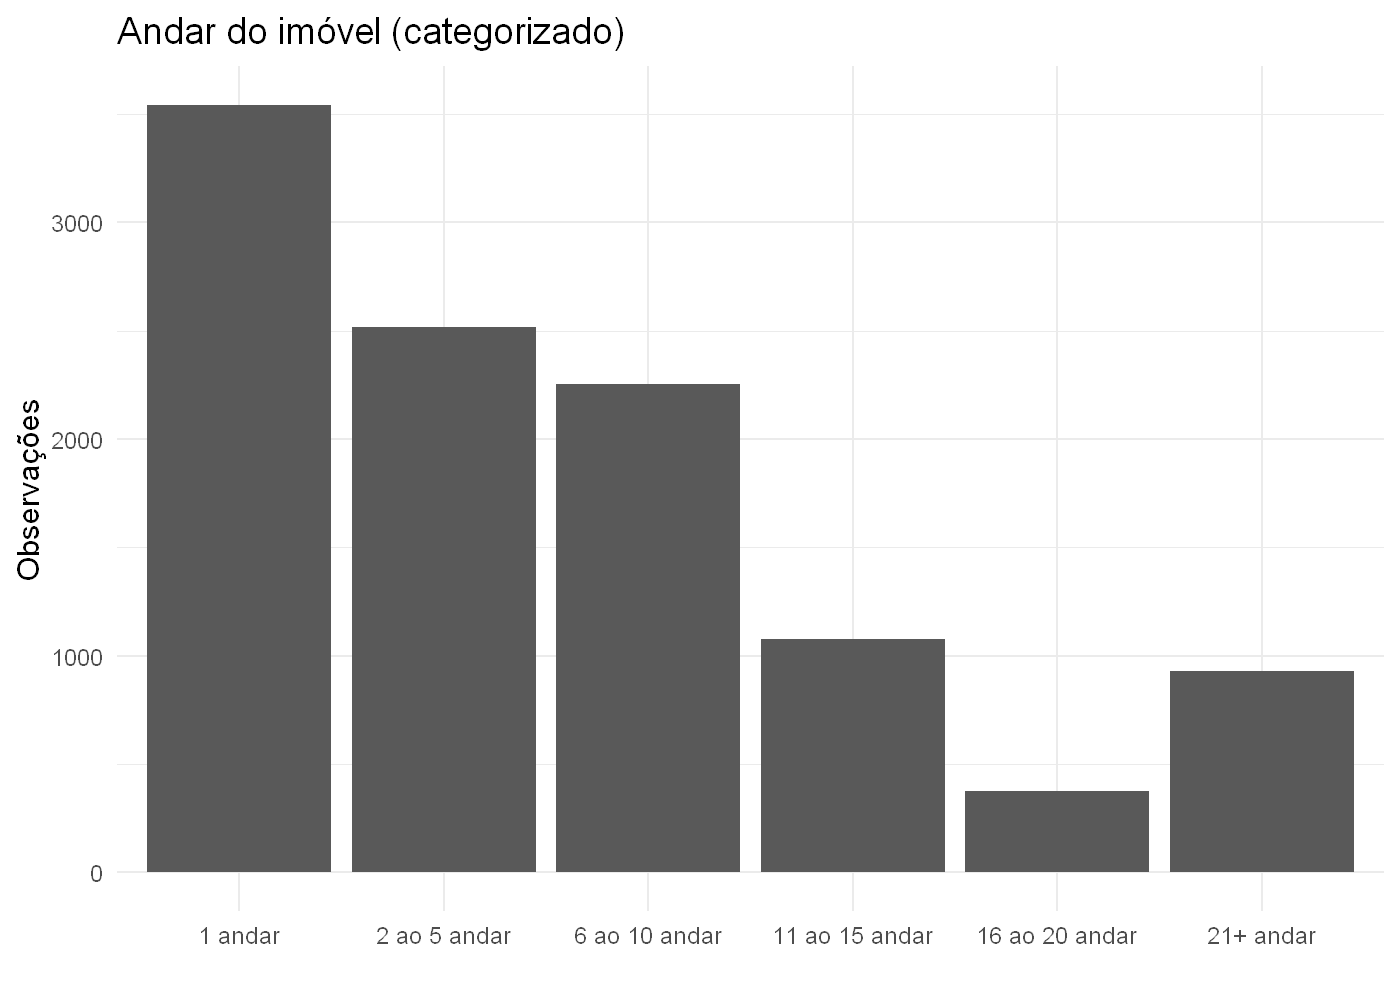

In [17]:
# cria a nova variavel de andar
df = df %>%
    mutate(floor_cat = case_when(
        (floor %in% c('-','1')) ~ '1 andar',
        (floor %in% c('2','3','5')) ~ '2 ao 5 andar',
        (floor %in% c('6','7','8','9','10')) ~ '6 ao 10 andar',
        (floor %in% c('11','12','13','14','15')) ~ '11 ao 15 andar',
        (floor %in% c('16','17','18','19','20')) ~ '16 ao 20 andar'
    )) %>%
    # demais serão 21+
    mutate(floor_cat = replace_na(floor_cat, '21+ andar'))

df$floor_cat %<>% factor(c('1 andar','2 ao 5 andar','6 ao 10 andar','11 ao 15 andar','16 ao 20 andar','21+ andar'))

# visualiza
ggplot(df) +
    geom_bar(aes(x=floor_cat)) +
    ggtitle(label = 'Andar do imóvel (categorizado)') +
    labs(x = '', y = 'Observações') +
    theme_minimal()

Existem diversas maneiras diferentes de criar essas macro categorias. Vai do conhecimento do problema e análise mais aprofundada do *dataset*.

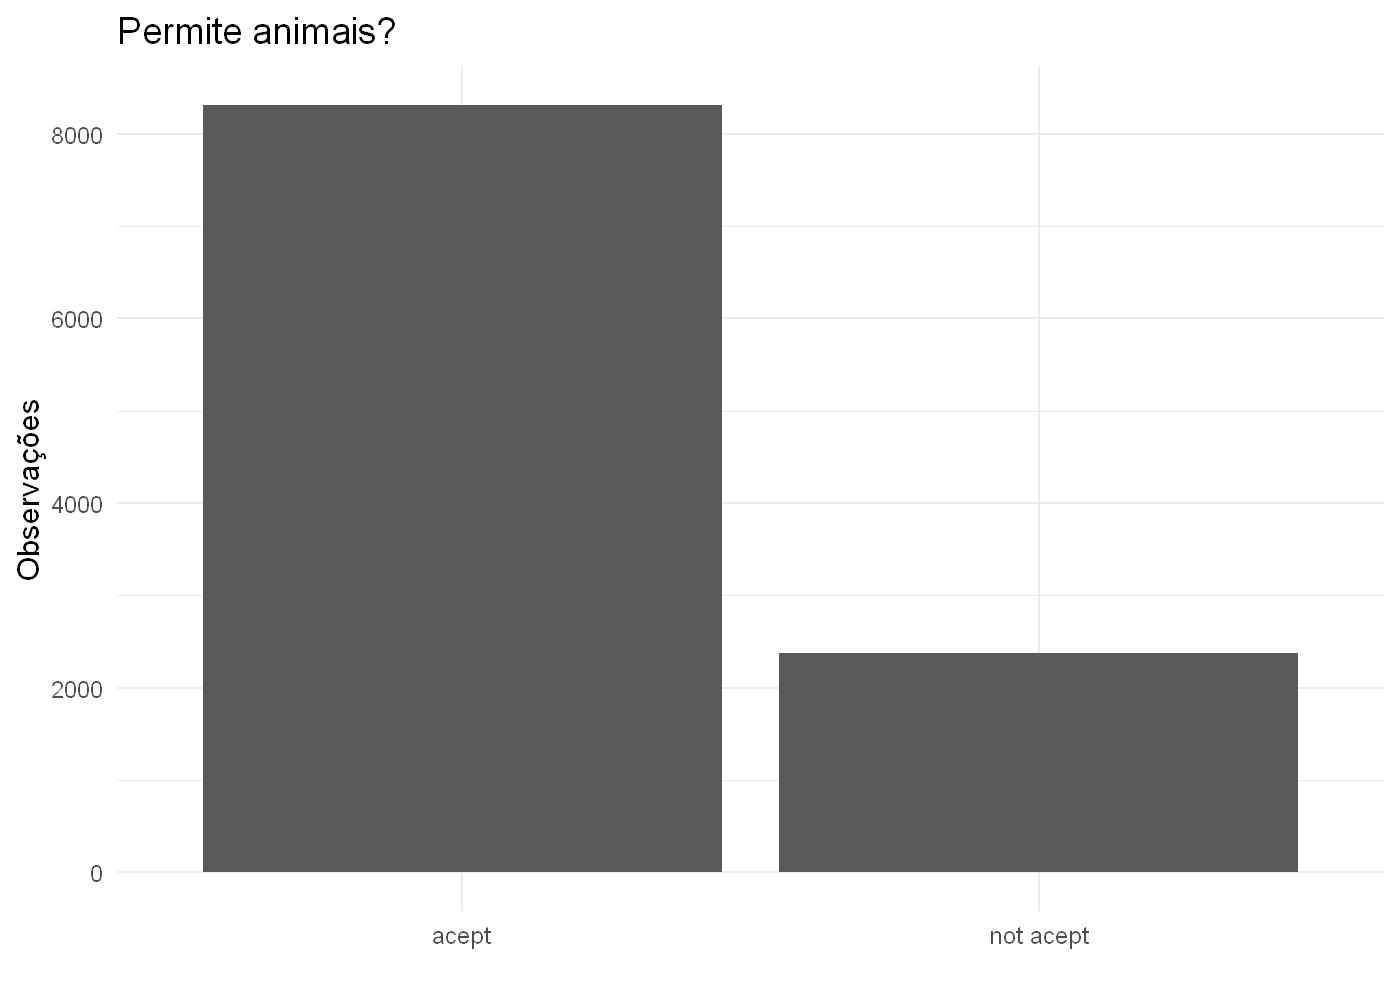

In [18]:
# permissão de animais
ggplot(df) +
    geom_bar(aes(x=animal)) +
    ggtitle(label = 'Permite animais?') +
    labs(x = '', y = 'Observações') +
    theme_minimal()

A maior parte dos imóveis permite animais.

Para facilitar a modelagem, vamos transformar essa variável em uma indicadora, que terá o valor 1 quando o imóvel aceita animais e 0 quando não.

In [19]:
# cria a indicadora
df = df %>% mutate(ind_animal = as.numeric(animal == 'acept'))

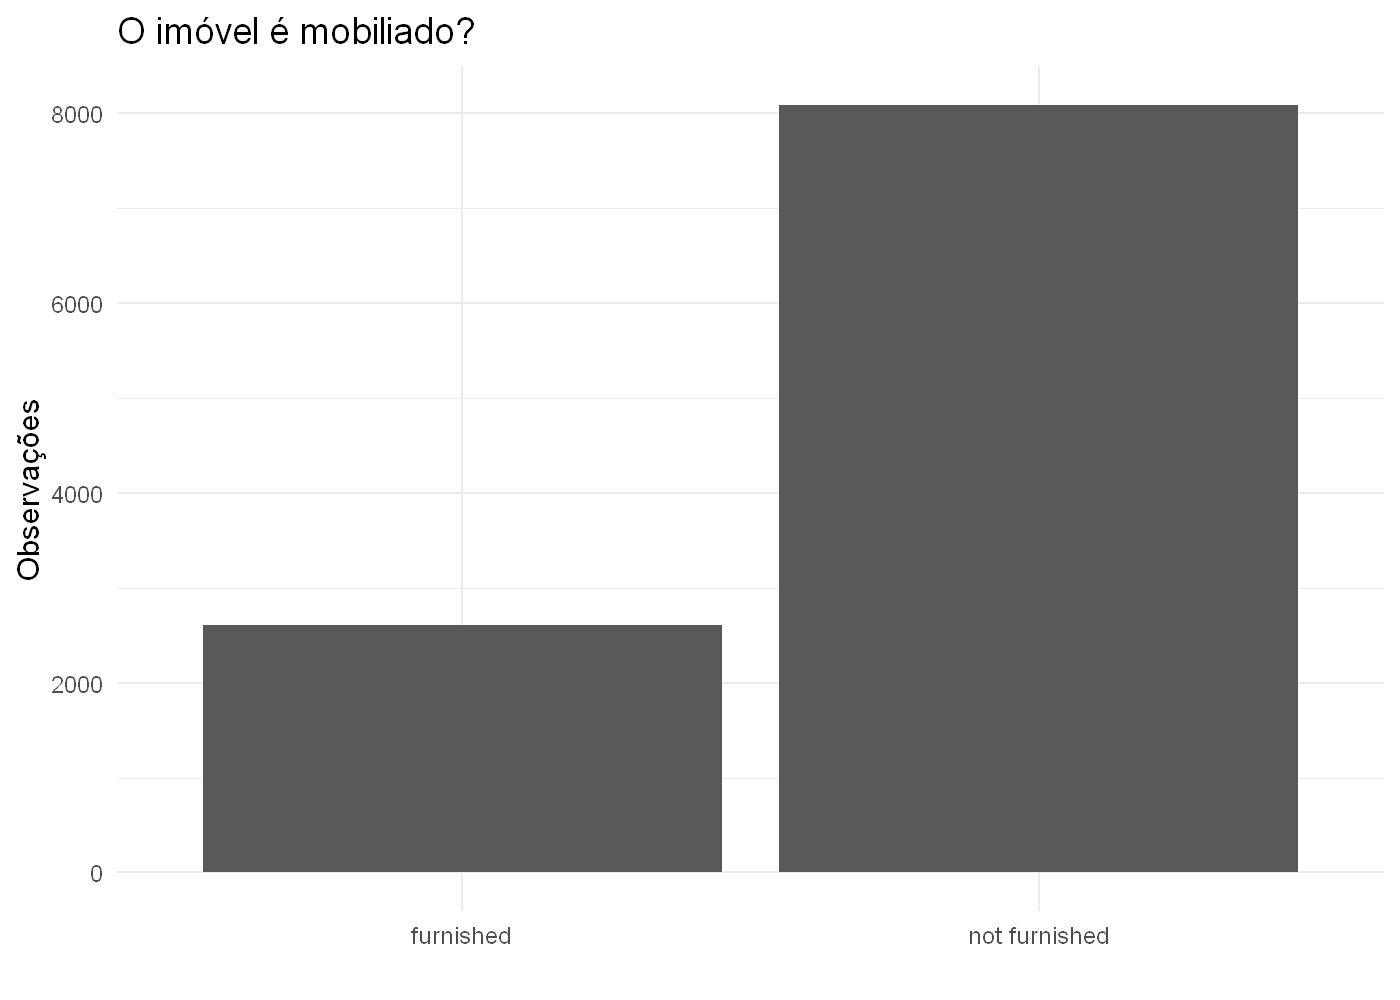

In [20]:
# mobília
ggplot(df) +
    geom_bar(aes(x=furniture)) +
    ggtitle(label = 'O imóvel é mobiliado?') +
    labs(x = '', y = 'Observações') +
    theme_minimal()

A maioria dos imóveis não têm mobília.

De forma similar ao feito na variável anterior, vamos tranformar essa variavel em indicadora.

In [21]:
# cria a indicadora
df = df %>% mutate(ind_furniture = as.numeric(furniture == 'furnished'))

As variáveis referentes aos valores específicos do imóvel (condomínio, aluguel, IPTU e seguro incêndio) não serão utilizadas pois elas compõem a variável resposta.

### Modelo interpretável

Primeiro será ajustado um modelo interpretável, uma regressão linear. O objetivo é prever o log do valor do imóvel utilizando as variáveis que exploramos.

In [22]:
## separa base do modelo
df_model = df %>% select(log_total, city, area, rooms, bathrooms, parking_spaces, floor_cat, ind_animal, ind_furniture)

print(paste('A base contém', nrow(df_model), 'observações e', ncol(df_model)-1, 'variáveis explicativas.'))

[1] "A base contém 10692 observações e 8 variáveis explicativas."


Como o objetivo não é fazer avaliação do modelo, nenhuma base de teste será separada. Vamos utilizar todas as observações para treino.

In [23]:
## ajusta regressão linear
linear = lm(log_total ~ ., data = df_model)
summary(linear)


Call:
lm(formula = log_total ~ ., data = df_model)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2948 -0.3138 -0.0384  0.2768  5.9458 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              7.050e+00  1.575e-02 447.584   <2e-16 ***
cityRio de Janeiro      -2.913e-03  1.405e-02  -0.207   0.8357    
cityBelo Horizonte      -3.693e-01  1.481e-02 -24.936   <2e-16 ***
cityPorto Alegre        -3.715e-01  1.515e-02 -24.525   <2e-16 ***
cityCampinas            -4.274e-01  1.715e-02 -24.924   <2e-16 ***
area                     1.789e-05  8.588e-06   2.083   0.0373 *  
rooms                    1.536e-01  5.995e-03  25.614   <2e-16 ***
bathrooms                2.189e-01  5.391e-03  40.601   <2e-16 ***
parking_spaces           1.043e-01  4.136e-03  25.206   <2e-16 ***
floor_cat2 ao 5 andar    1.796e-01  1.251e-02  14.359   <2e-16 ***
floor_cat6 ao 10 andar   3.230e-01  1.274e-02  25.362   <2e-16 ***
floor_cat11 ao 15 andar  3.700e-01 

No modelo de regressão linear, a importância da *feature* é o tamanho absoluto do coeficiente da *feature*. A variável `ind_furniture`, por exemplo, tem coeficiente 0,3288. A interpretação é que imóveis com mobília têm log do valor total maior em 0,3288 do que imóveis sem mobília, em média. Dessa forma, quanto maior o coeficiente, maior o efeito (importância) daquela *feature* no valor predito.

As *features* categóricas são transformadas em variáveis indicadoras. A variável `city`, por exemplo, tem 5 categorias e foi transformada em 4 indicadoras, tendo a cidade de São Paulo como a referência. Em Belo Horizonte, por exemplo, o log do valor total é menor em 0,3693 do que imóveis em São Paulo. Nesse caso, a importância é medida para cada categoria, e não para a variável como um todo.

É importante destacar que, dependendo da referência, os coeficientes serão diferentes. Vale avaliar qual categoria faria mais sentido ser usada como base no problema.

**Importante:**

Existem vários pontos que precisam ser checados no ajuste de uma regressão linear. Um deles é a multicolinearidade (correlação entre as *features* do modelo). *Features* correlacionadas positivamente podem acabar tendo coeficientes opostos para que uma compense a outra, por exemplo, ou então diminuir a importância individual de cada *feature*.

Existem 4 *features* na base de treino que, logo de cara, já se imagina que exista forte correlação: o número de quartos, o número de banheiros, o número de vagas de garagem e a área do apartamento.

In [24]:
# correlação entre número de quartos e número de banheiros
cor(df_model$rooms, df_model$bathrooms)

[1] 0.7337635

In [25]:
# correlação entre número de quartos e número de vagas de garagem
cor(df_model$rooms, df_model$parking_spaces)

[1] 0.6175096

In [26]:
# correlação entre número de quartos e a área do apartamento
cor(df_model$rooms, df_model$area)

[1] 0.1937963

Existe forte correlação entre o número de quartos e o número de banheiros, e entre o número de quartos e o número de vagas de garagem.

A correlação entre o número de quartos e a área do imóvel é positiva e significativa, mas leve. Portanto não vamos fazer alterações no momento.

Para resolver a multicolinearidade, pode-se remover as variáveis correlacionadas (deixar apenas uma delas) ou fazer modificações que removam a correlação entre elas (*feature engineering*). Aqui vamos utilizar a segunda solução.

In [27]:
# calcula número de banheiros/número de vagas por quarto
df_model = df_model %>%
    mutate(bathrooms_ratio = bathrooms/rooms,
           parking_ratio = parking_spaces/rooms)

# confere as correlações
cor(df_model$rooms, df_model$bathrooms_ratio)

[1] -0.09960391

In [28]:
# confere as correlações
cor(df_model$rooms, df_model$parking_ratio)

[1] 0.1938793

As correlações foram diminuídas com as novas features. Daí, ajusta-se um novo modelo.

In [29]:
## ajusta novo modelo com novas features e removendo as antigas
linear2 = lm(log_total ~ ., data = df_model %>% select(-c('bathrooms','parking_spaces')))
summary(linear2)


Call:
lm(formula = log_total ~ ., data = df_model %>% select(-c("bathrooms", 
    "parking_spaces")))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8275 -0.3018 -0.0308  0.2758  4.8560 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              6.301e+00  2.021e-02 311.846  < 2e-16 ***
cityRio de Janeiro       5.417e-03  1.374e-02   0.394 0.693342    
cityBelo Horizonte      -3.907e-01  1.442e-02 -27.099  < 2e-16 ***
cityPorto Alegre        -3.728e-01  1.478e-02 -25.225  < 2e-16 ***
cityCampinas            -4.332e-01  1.675e-02 -25.856  < 2e-16 ***
area                     2.892e-05  8.363e-06   3.457 0.000548 ***
rooms                    4.271e-01  4.114e-03 103.809  < 2e-16 ***
floor_cat2 ao 5 andar    1.749e-01  1.219e-02  14.349  < 2e-16 ***
floor_cat6 ao 10 andar   3.069e-01  1.242e-02  24.705  < 2e-16 ***
floor_cat11 ao 15 andar  3.443e-01  1.591e-02  21.645  < 2e-16 ***
floor_cat16 ao 20 andar  3.476e-01  2.469e-02  14.0

Depois da modificação, a *feature* de maior importância é a `bathrooms_ratio` que foi criada, o número de banheiros por quarto. A importância do número de quartos também foi maior do que no modelo anterior.

A indicadora de permissão de animais é a de menor coeficiente, seguida pela indicadora do Rio de Janeiro, ambas não significaticas no modelo (valor-p 0.718 e 0.693, respectivamente). A primeira, por exemplo, poderia ser removida completamente do modelo. A segunda indica que não existe diferença significativa entre os preços em São Paulo e no Rio de Janeiro, o que pode sugerir que as categorias sejam unidas.

### Modelo *black-box*

O modelo de tipo *black-box* que será ajustado é um *Gradient Boosting Machine (GBM)*, utilizando o pacote H2O. A documentação do pacote pode ser encontrada [aqui](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html).

O *GBM* é um algoritmo de *ensemble*, ou seja, combinação de modelos. Nesse caso, é a combinação de árvores de decisão de forma sequencial, utilizando a técnica de *boosting*. É um algoritmo do tipo *black-box* pois a interpretação dos efeitos das *features* não é direta.

In [30]:
## inicia o h2o
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         9 hours 48 minutes 
    H2O cluster timezone:       America/Sao_Paulo 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.7 
    H2O cluster version age:    7 days, 3 hours and 41 minutes  
    H2O cluster name:           H2O_started_from_R_Jessica_ytd558 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.47 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.2 (2020-06-22) 



Novamente, como o foco não é performance, não será realizado nenhum tipo de otimização de hiperparâmetros. O ajuste será feito com os valores *default* que podem ser encontrados na documentação.

Vamos utilizar as variáveis de número de banheiros e vagas de garagem originais, pois o modelo GBM não tem premissa relacionada a multicolinearidade.

In [31]:
## sobe o dataset para o cluster
df_model2 = df %>% select(log_total, city, area, rooms, bathrooms, parking_spaces, floor_cat, ind_animal, ind_furniture)
df_model_h2o = as.h2o(df_model2)

## ajusta o modelo
gbm = h2o.gbm(y = 'log_total', training_frame = df_model_h2o)
gbm

  |======================================================================| 100%
  |======================================================================| 100%


Model Details:

H2ORegressionModel: gbm
Model ID:  GBM_model_R_1595945589050_14 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50               21635         5
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         5    5.00000         19         32    29.78000


H2ORegressionMetrics: gbm
** Reported on training data. **

MSE:  0.1312643
RMSE:  0.3623042
MAE:  0.2776898
RMSLE:  0.03854857
Mean Residual Deviance :  0.1312643





No sumário do modelo temos que foram ajustadas 50 árvores, com profundidade máxima 5. Para ver a importância das *features*, utilizamos o pacote `vip`.

No caso de *features* categóricas, o H2O cria internamente as indicadoras e o resultado das *feature importances* pode ser visto agrupado.

Primeiro vamos calcular a importância utilizando *Permutation Feature Importance*. A métrica de erro utilizada será o *Mean Squared Error*.

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

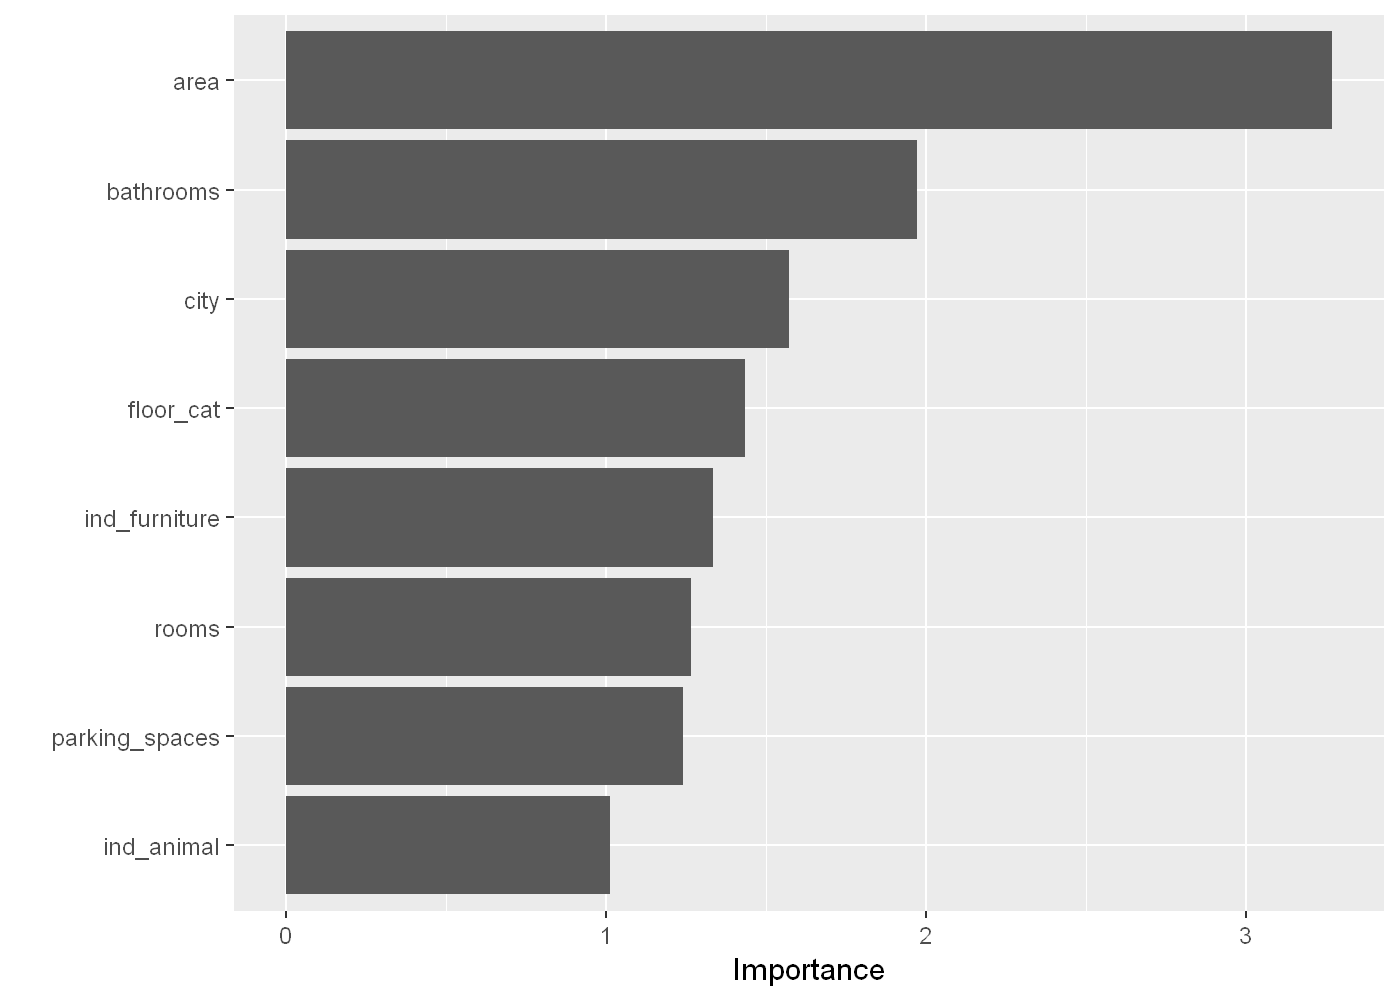

In [32]:
## importância das features (model-agnostic)
# função de predição
pred_gbm = function(object, newdata) {
    result = as.vector(h2o.predict(object, as.h2o(newdata)))
    return(result)
}

# gráfico
vip(gbm, num_features = 8, method = 'permute', pred_wrapper = pred_gbm,
   train = df_model2, target = 'log_total', metric = 'mse', type = 'ratio')

Utilizando *Permutation feature Importance* a variável de maior importância é a área do imóvel, seguido pelo número de banheiros e a cidade. Esse resultado é diferente do encontrado na regressão linear. Uma explicação para isso é o fato de que o GBM consegue identificar relações não-lineares entre as *features* e a variável resposta.

A importância também pode ser calculada utilizando métodos específicos para aquele tipo de modelo.

Warning message:
"`as.tibble()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


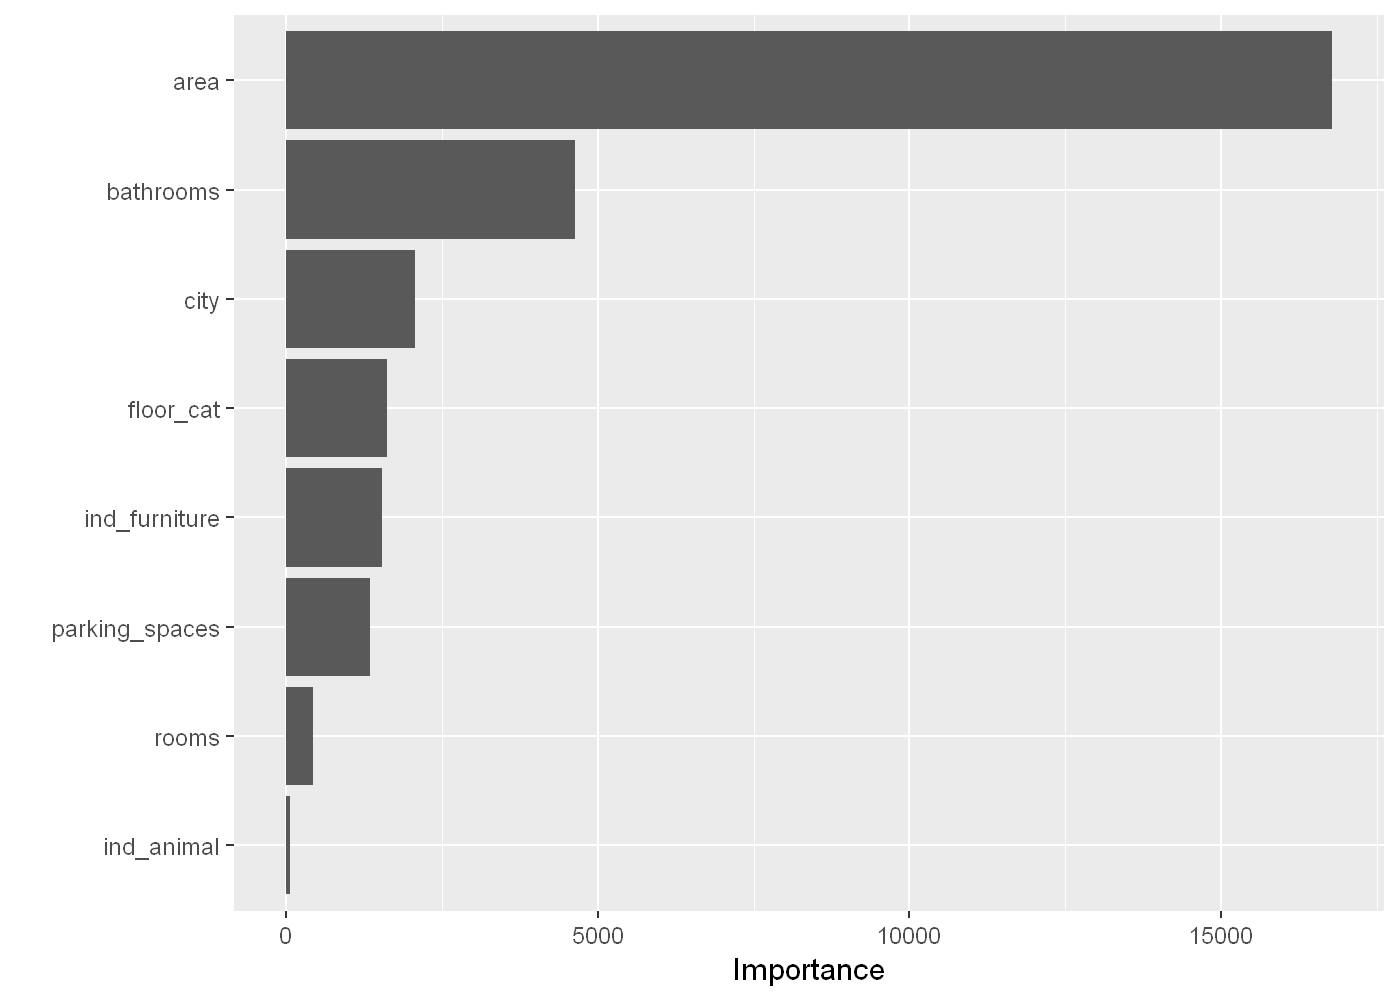

In [33]:
## importância das features
vip(gbm, num_features = 8)

Nesse resultado a área do imóvel tem a maior *feature importance*, bem maior do que a importância das demais variáveis. O resultado é semelhante ao obtido no método de permutação em termo de ordem das variáveis por importância.

Uma possibilidade no `vip` é modificar os aspectos do gráfico, já que se trata de um gráfico construído com o pacote `ggplot2`. Isso pode ser feito pelos parâmetros `geom`, `mapping` e `aesthetics`, entre outros. A documentação do `vip`pode ser vista [aqui](https://cran.r-project.org/web/packages/vip/vip.pdf). Também pode ser feito apenas adicionando funções do `ggplot2`, como aplicar um tema.

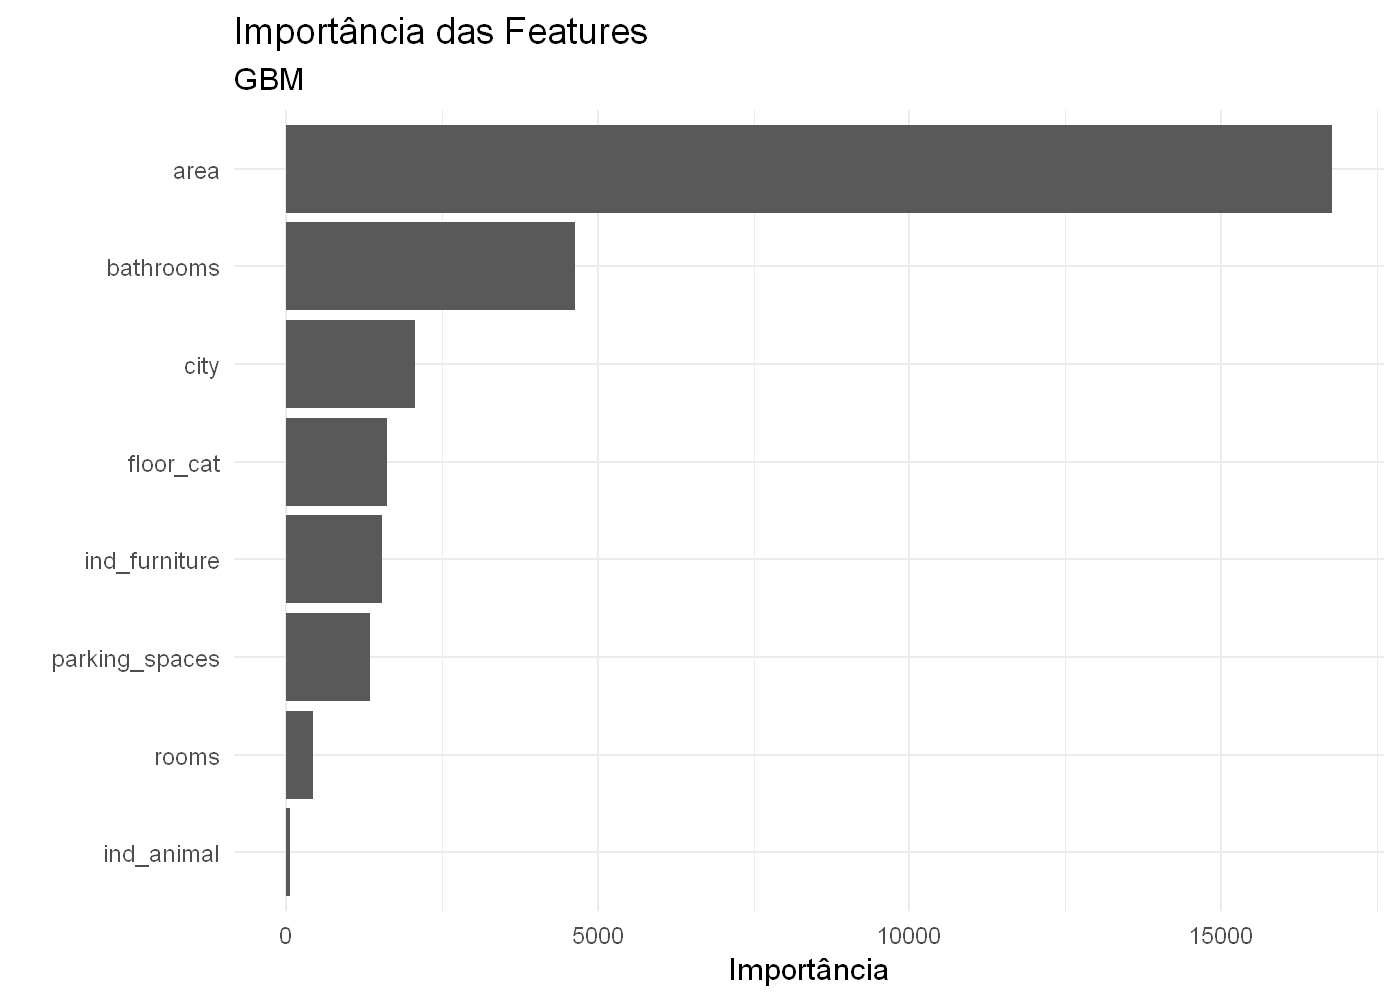

In [34]:
## modificando a aparência do gráfico
vip(gbm, num_features = 8) +
    labs(y = 'Importância') +
    ggtitle('Importância das Features',
            subtitle = 'GBM') +
    theme_minimal()

O H2O também contém uma função que devolve uma tabela com a importância que vemos no gráfico acima, a importância numa escala de 0 a 1 (onde 1 é a importância da variável mais importante) e o percentual da importância total.

In [36]:
## importância das features pelo H2O
h2o.varimp(gbm)

variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
area,16778.15234,1.000000000,0.588772034
bathrooms,4631.70850,0.276055933,0.162534013
city,2078.50952,0.123881908,0.072938203
floor_cat,1615.83911,0.096306141,0.056702363
ind_furniture,1542.04834,0.091908114,0.054112927
parking_spaces,1346.97839,0.080281688,0.047267613
rooms,431.39185,0.025711523,0.015138226
ind_animal,72.22873,0.004304927,0.002534621


O que a função `vip` faz é utilizar a função do H2O para obter as importâncias. O pacote `vip`tem suporte para os principais pacotes de *machine learning* no R, inclusive `caret` e `randomForest`.

O cálculo da importância das features utilizando essa função é específico para modelos baseados em árvore. É possível encontrar mais informações sobre o cálculo das *feature importances* no H2O nesse [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/variable-importance.html).